# CHAPTER 07 머신러닝을 이용한 광물자원탐사 융합해석

## 2. 머신러닝 기법을 활용한 잠재광상예측 실습

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("max_info_rows", 6000000)

In [4]:
data_all = pd.read_csv('./Data/data.csv')
data_all.replace(-99999, np.nan, inplace=True)
data_all.dropna(inplace=True)
data_all.reset_index(drop=True, inplace=True)

#prepare training and test data
training_data = data_all.loc[data_all['Massive_Sulphide_Training_cells'] != -1]
test_data = data_all.loc[data_all['Massive_Sulphide_Training_cells'] == -1]
test_data = test_data.drop(['Massive_Sulphide_Training_cells'],axis=1)
test_data = test_data.loc[(test_data['ROCK_code_classified']!=16)]

training_data.head()

,U,V,W,ROCK_code_classified,MAGNETIC_inversion,dist2_FAULTS,dist2_SEISMIC_anomalies,dist2_VSED_contact,Massive_Sulphide_Training_cells
103,103,0,48,12,0.009377,216.078629,805.808289,308.276794,0.0
354,43,1,48,15,0.008394,506.101318,1248.874878,117.596367,0.0
1635,80,5,48,12,0.007910,29.086609,942.339600,9.756816,0.0
3078,279,9,48,12,0.008661,791.265076,473.602448,1089.007568,0.0
4644,290,14,48,12,0.007885,722.383606,312.149384,1077.848022,0.0


# 상관도 분석

In [5]:
facies_colors = ['#FF0000', '#0000FF']

facies_labels = ['Not Sulphides', 'Sulphides']

facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ int(row['Massive_Sulphide_Training_cells'])]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)

C:\Users\Daeung\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Daeung\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


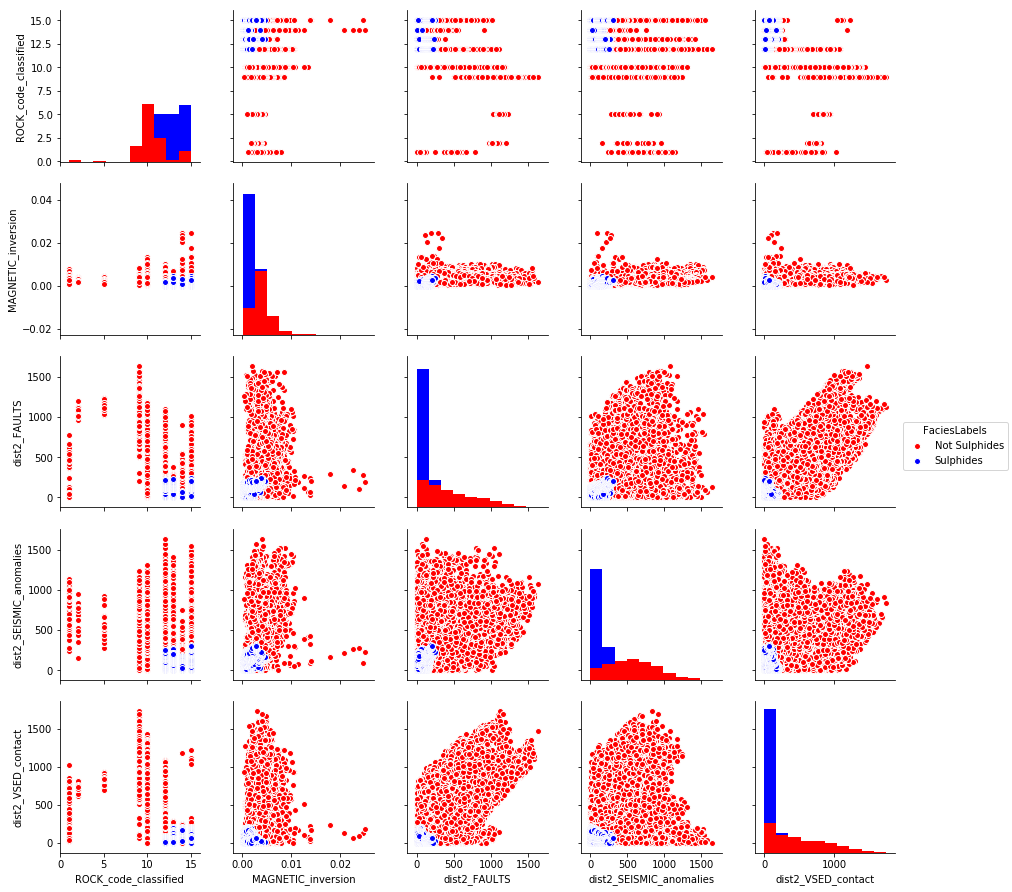

In [6]:
import seaborn as sns
sns.pairplot(training_data.drop(['U', 'V', 'W', 'Massive_Sulphide_Training_cells'], axis=1),
             hue="FaciesLabels", palette=facies_color_map, hue_order=list(facies_labels))

# 3D 가시화

In [ ]:
import vtk
from vtk.util import numpy_support

df = data_all

dims = [312,149,183]
cdims= [311,148,182]
cellsize = 15

df['index'] = df['W']*cdims[0]*cdims[1] + df['V']*cdims[0] + df['U']

voxet = vtk.vtkStructuredGrid()
voxet.SetDimensions(dims[0],dims[1],dims[2])

points = vtk.vtkPoints()

x = np.arange(dims[0])*15.
y = np.arange(dims[1])*15.
z = np.arange(dims[2])*15.
yv, zv, xv = np.meshgrid(y, z, x) # 2,3,1

xyz = np.hstack((xv.reshape(-1,1),
                 yv.reshape(-1,1),
                zv.reshape(-1,1)))

dataArray = numpy_support.numpy_to_vtk(xyz, 1, vtk.VTK_FLOAT)
points.SetData(dataArray)
voxet.SetPoints(points)

celldata = vtk.vtkFloatArray()
celldata.SetNumberOfTuples(cdims[0]*cdims[1]*cdims[2])

np_celldata = np.full((cdims[0]*cdims[1]*cdims[2],), np.nan)
np_celldata[df['index']] = df['ROCK_code_classified']

celldata = numpy_support.numpy_to_vtk(np_celldata, 1, vtk.VTK_FLOAT)
celldata.SetName("ROCK_code_classified")
voxet.GetCellData().AddArray(celldata)
voxet.GetCellData().SetActiveScalars("ROCK_code_classified")

lut = vtk.vtkLookupTable()
lut.Build()
lut.SetNanColor(1, 1, 1, 1)

mapper = vtk.vtkDataSetMapper()
mapper.SetInputData(voxet)
mapper.SetScalarRange(0, 16) # how to map original scalar to min-max table value
mapper.SetLookupTable(lut)
mapper.SetScalarModeToUseCellData()

actor = vtk.vtkActor()
actor.SetMapper(mapper)

ren = vtk.vtkRenderer()
ren.SetBackground(0.5, 0.5, 0.5)
ren.TwoSidedLightingOff()

txt = vtk.vtkTextActor()
txt.SetInput("Press Q to quit")
txtprop = txt.GetTextProperty()
txtprop.SetFontFamilyToArial()
txtprop.SetFontSize(18)
txtprop.SetColor(1, 1, 1)
txt.SetDisplayPosition(20, 60)

ren.AddActor(txt)
ren.AddActor(actor)
ren.ResetCamera()

class VtkViewer:
    def __init__(self, renderer):
        self.ren = renderer        
        
    def keyCallbacks(self, obj, event):
        key = self.iren.GetKeySym()
        if key is 'q':
            self.renWin.Finalize()
            self.iren.TerminateApp()
            del self.renWin, self.iren
    
    def show(self):
        self.renWin = vtk.vtkRenderWindow()        
        self.renWin.SetSize(800, 800)
        self.renWin.AddRenderer(self.ren)
        
        self.iren = vtk.vtkRenderWindowInteractor()
        self.iren.SetRenderWindow(self.renWin)
        self.iren.AddObserver("KeyPressEvent", self.keyCallbacks)        
        self.iren.Initialize()
        self.iren.Start()


viewer = VtkViewer(ren)
viewer.show()

#display magnetic inversion
np_celldata = np.full((cdims[0]*cdims[1]*cdims[2],), np.nan)
np_celldata[df['index']] = df['MAGNETIC_inversion']
celldata = numpy_support.numpy_to_vtk(np_celldata, 1, vtk.VTK_FLOAT)
celldata.SetName("MAGNETIC_inversion")
voxet.GetCellData().AddArray(celldata)
voxet.GetCellData().SetActiveScalars("MAGNETIC_inversion")
mapper.SetScalarRange(np.nanmin(np_celldata), np.nanmax(np_celldata))
viewer.show()

#display dist2_FAULTS
np_celldata = np.full((cdims[0]*cdims[1]*cdims[2],), np.nan)
np_celldata[df['index']] = df['dist2_FAULTS']
celldata = numpy_support.numpy_to_vtk(np_celldata, 1, vtk.VTK_FLOAT)
celldata.SetName("dist2_FAULTS")
voxet.GetCellData().AddArray(celldata)
voxet.GetCellData().SetActiveScalars("dist2_FAULTS")
mapper.SetScalarRange(np.nanmin(np_celldata), np.nanmax(np_celldata))
viewer.show()

#display dist2_SEISMIC_anomalies
np_celldata = np.full((cdims[0]*cdims[1]*cdims[2],), np.nan)
np_celldata[df['index']] = df['dist2_SEISMIC_anomalies']
celldata = numpy_support.numpy_to_vtk(np_celldata, 1, vtk.VTK_FLOAT)
celldata.SetName("dist2_SEISMIC_anomalies")
voxet.GetCellData().AddArray(celldata)
voxet.GetCellData().SetActiveScalars("dist2_SEISMIC_anomalies")
mapper.SetScalarRange(np.nanmin(np_celldata), np.nanmax(np_celldata))
viewer.show()

#display dist2_VSED_contact
np_celldata = np.full((cdims[0]*cdims[1]*cdims[2],), np.nan)
np_celldata[df['index']] = df['dist2_VSED_contact']
celldata = numpy_support.numpy_to_vtk(np_celldata, 1, vtk.VTK_FLOAT)
celldata.SetName("dist2_VSED_contact")
voxet.GetCellData().AddArray(celldata)
voxet.GetCellData().SetActiveScalars("dist2_VSED_contact")
mapper.SetScalarRange(np.nanmin(np_celldata), np.nanmax(np_celldata))
viewer.show()

#Massive_Sulphide_Traning_cells    
GHOST_ARRAY_NAME = "vtkGhostType"
HIDDEN = 32
NOT_HIDDEN= 0

#need np.unit8, np double doens't converted to vtk unsigned char array
np_hidden_cell = np.full(cdims[0]*cdims[1]*cdims[2], HIDDEN, np.uint8)
np_hidden_cell[df.loc[df['Massive_Sulphide_Training_cells'] == 1]['index']] = NOT_HIDDEN #unblank cell

ghost_celldata = numpy_support.numpy_to_vtk(np_hidden_cell, vtk.VTK_UNSIGNED_CHAR)

ghost_celldata.SetName(GHOST_ARRAY_NAME)
voxet.GetCellData().AddArray(ghost_celldata)
voxet.UpdateCellGhostArrayCache()
viewer.show()

#reset
np_hidden_cell = np.full(cdims[0]*cdims[1]*cdims[2], NOT_HIDDEN, np.uint8)
ghost_celldata = numpy_support.numpy_to_vtk(np_hidden_cell, vtk.VTK_UNSIGNED_CHAR)

ghost_celldata.SetName(GHOST_ARRAY_NAME)
voxet.GetCellData().AddArray(ghost_celldata)
voxet.UpdateCellGhostArrayCache()

xmlWriter = vtk.vtkXMLStructuredGridWriter()
xmlWriter.SetInputData(voxet)
xmlWriter.SetFileName('voxet_all.vts')
xmlWriter.Write()

C:\Users\Daeung\Anaconda3\lib\site-packages\vtk\util\numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


# 훈련/검증 셋 분리

In [ ]:
from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(training_data, test_size=0.2, stratify=training_data['Massive_Sulphide_Training_cells'],
                                      random_state=10)

# 전처리 데이터 파이프라인 구성

In [ ]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

num_attribs = ["MAGNETIC_inversion", "dist2_FAULTS", "dist2_SEISMIC_anomalies", "dist2_VSED_contact"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
    ])


cat_attribs = ["ROCK_code_classified"]
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

# 훈련/검증 입력값, 레이블 준비
전처리 파이프라인(full_pipeline)을 이용하여 입력, 레이블 준비

In [ ]:
X_train = full_pipeline.fit_transform(train_set)
y_train = train_set['Massive_Sulphide_Training_cells'].values

In [ ]:
X_val = full_pipeline.transform(val_set)
y_val = val_set['Massive_Sulphide_Training_cells'].values

# 모델 훈련하고 검증하기

데이터가 단순하고 쉽게 분리가 가능하므로 신경망을 제외한 결정 트리, 랜덤 포레스트, 그레디언트 부스팅, 로지스틱 회귀, 서포트 벡터 머신 모델을 훈련하였고, 검증 데이터로 정확도를 확인하였다

단 로지스틱 회귀, 서포트 벡터 머신 모델을 스케일에 민감하므로 standard 스케일링을 적용하여 파이프라인을 구성하였다. 

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier

tree_clf = DecisionTreeClassifier(max_depth=3, random_state=10)

rnd_clf = RandomForestClassifier(n_estimators=10, max_depth=8, random_state=10)

gbst_clf = GradientBoostingClassifier(n_estimators=200, max_depth=5, random_state=10)

lgst_clf = LogisticRegression(C=100)

svm_clf = SVC(kernel="rbf", gamma=10, C=1000, probability=True)

for clf in (tree_clf, rnd_clf, gbst_clf, lgst_clf, svm_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print(clf.__class__.__name__, accuracy_score(y_val, y_pred))
        

최종 모델로 검증 정확도가 가장 높은 GradientBoostingClassifier 모델을 선택하였다.

# 테스트 데이터 적용 및 예측 잠재광상 3D 가시화

In [ ]:
X_test = full_pipeline.transform(test_data)

In [ ]:
y_pred = gbst_clf.predict(X_test)

In [ ]:
predicted_df = test_data[['U', 'V', 'W']]
predicted_df['index'] = predicted_df['W']*cdims[0]*cdims[1] + predicted_df['V']*cdims[0] + predicted_df['U']
predicted_df['predicted'] = y_pred

np_hidden_cell = np.full(cdims[0]*cdims[1]*cdims[2], HIDDEN, np.uint8)
np_hidden_cell[predicted_df.loc[predicted_df['predicted'] == 1]['index']] = NOT_HIDDEN #unblank cell

training_sulphide = training_data.loc[training_data["Massive_Sulphide_Training_cells"] == 1]
training_sulphide['index'] = training_sulphide['W']*cdims[0]*cdims[1] + training_sulphide['V']*cdims[0] + training_sulphide['U']
np_hidden_cell[training_sulphide['index']] = NOT_HIDDEN #unblank cell

ghost_celldata = numpy_support.numpy_to_vtk(np_hidden_cell, vtk.VTK_UNSIGNED_CHAR)

ghost_celldata.SetName(GHOST_ARRAY_NAME)
voxet.GetCellData().AddArray(ghost_celldata)
voxet.UpdateCellGhostArrayCache()

#training: 1, predicted: 2, both: 3

np_celldata = np.full((cdims[0]*cdims[1]*cdims[2],), 0)
np_celldata[training_sulphide['index']] += 1
np_celldata[predicted_df['index']] += 2
celldata = numpy_support.numpy_to_vtk(np_celldata, 1, vtk.VTK_FLOAT)
celldata.SetName("training_and_predicted")
voxet.GetCellData().AddArray(celldata)
voxet.GetCellData().SetActiveScalars("training_and_predicted")
mapper.SetScalarRange(np.nanmin(np_celldata), np.nanmax(np_celldata))
ren.ResetCamera()
viewer.show()

#reset
np_hidden_cell = np.full(cdims[0]*cdims[1]*cdims[2], NOT_HIDDEN, np.uint8)
ghost_celldata = numpy_support.numpy_to_vtk(np_hidden_cell, vtk.VTK_UNSIGNED_CHAR)

ghost_celldata.SetName(GHOST_ARRAY_NAME)
voxet.GetCellData().AddArray(ghost_celldata)
voxet.UpdateCellGhostArrayCache()